In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [8]:
img_height, img_width = (300,300)
IMG_SIZE = (img_height, img_width)
IMG_SIZE_RGB = IMG_SIZE + (3,)
batch_size = 32

data_directory = "dataset2"

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="training",
    validation_split=0.2,
    seed=69420,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 744 files belonging to 7 classes.
Using 596 files for training.


In [10]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="validation",
    validation_split=0.2,
    seed=69420,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 744 files belonging to 7 classes.
Using 148 files for validation.


In [14]:
class_names = train_data.class_names
train_data.class_names

['1_polyethylene_PET',
 '2_high_density_polyethylene_PE-HD',
 '3_polyvinylchloride_PVC',
 '4_low_density_polyethylene_PE-LD',
 '5_polypropylene_PP',
 '6_polystyrene_PS',
 '7_other_resins']

2023-06-03 03:53:33.902554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


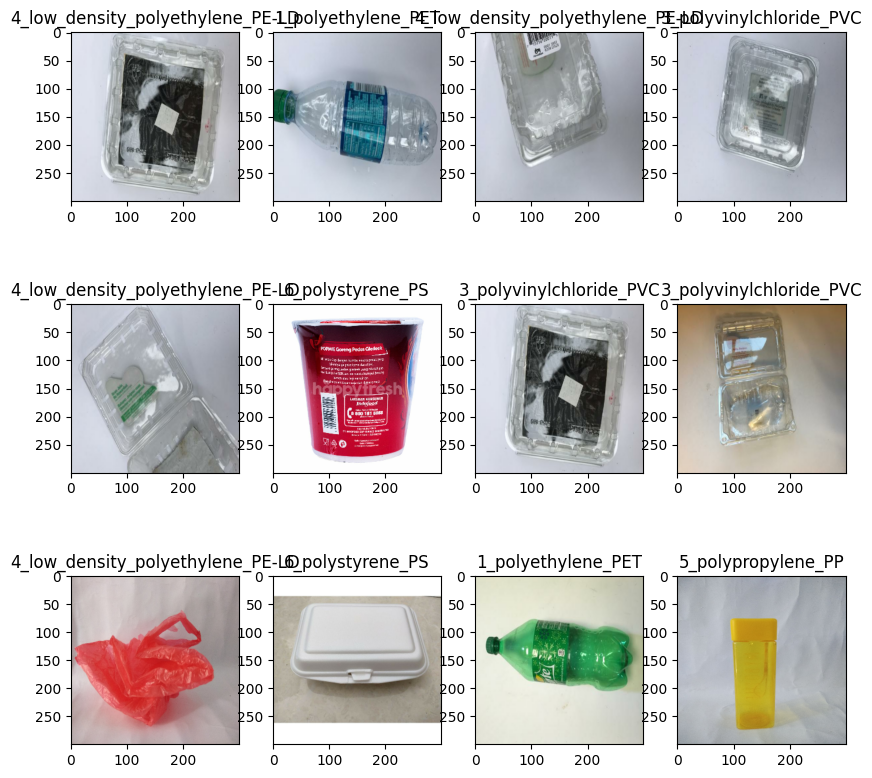

In [15]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range (12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = class_names[label_batch[i]]
    plt.title(label)

In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE_RGB,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

In [17]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(len(class_names))

2023-06-03 03:54:00.625488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomRotation(40),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SIZE_RGB),
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input),
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    prediction_layer
])


learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 lambda_4 (Lambda)           (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                

In [25]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(validation_data)

2023-06-03 03:55:32.743678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5/5 [==============================] - 3s 196ms/step - loss: 2.7096 - accuracy: 0.1419


In [26]:
loss0, accuracy0

(2.7096152305603027, 0.14189189672470093)

In [27]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)

Epoch 1/300


2023-06-03 03:55:49.784202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/19 [==============================] - ETA: 0s - loss: 1.9026 - accuracy: 0.2651

2023-06-03 03:57:28.810849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


19/19 [==============================] - 105s 5s/step - loss: 1.9026 - accuracy: 0.2651 - val_loss: 2.9632 - val_accuracy: 0.1014
Epoch 2/300


2023-06-03 03:57:32.100776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/19 [==>...........................] - ETA: 1:46 - loss: 1.4492 - accuracy: 0.5000

KeyboardInterrupt: 